# CLUB algorithm draft - Online Clustering of Bandits

In [3]:
import numpy as np
import numpy.random as npr
import numpy.linalg
import pandas as pd
from scipy.spatial.distance import euclidean
import networkx as nx
import matplotlib.pyplot as plt

### Commentaires
 
Problème de convergence: sur une période suffisamment longue, on supprime tous les noeuds du graphe <br>

J'ai l'impression que la norme euclidienne (omega_i,omega_l) est beaucoup trop volatile par rapport aux CB. Et quand cette norme prend des valeurs très hautes, la condition "brise le lien" est satisfaite.<br>

La payoff a_t n'est pas toujours dans [-1,1]<br>

Le regret est quasi-linéaire -> l'algo n'apprend rien

# Initialisation

In [196]:
#tests
V=nx.Graph()
V.add_node(1)
V.add_node(2)
V.add_node(3)
V.add_edge(1,2)
V.add_edge(3,2)
print(V.adj)

{1: {2: {}}, 2: {1: {}, 3: {}}, 3: {2: {}}}


In [82]:
V=nx.Graph(np.ones([4,4]))
#V=nx.Graph(np.identity(3))
#print(V.adj)
print(V[1])

{0: {'weight': 1.0}, 1: {'weight': 1.0}, 2: {'weight': 1.0}, 3: {'weight': 1.0}}


In [83]:
V.remove_edge(0,1)
V.remove_edge(0,3)
V.remove_edge(3,1)
V.remove_edge(0,2)

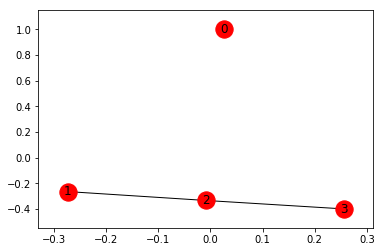

In [84]:
nx.draw_networkx(V)
plt.show()

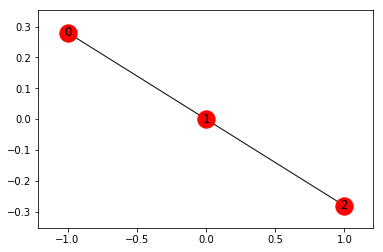

In [173]:
G=nx.Graph()
G=nx.compose(G,nx.path_graph(3))
nx.draw_networkx(G)
plt.show()

In [101]:
len( list( nx.connected_component_subgraphs(G) ) )

3

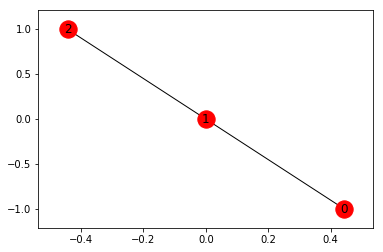

In [96]:
nx.draw_networkx(list(nx.connected_component_subgraphs(G))[2])
plt.show()

In [206]:
[n for n in V if V.has_edge(1,n)]

[1, 2]

In [221]:
nx.has_path(V,1,0)

False

In [2]:
#sphere unitaire pour générer les matrices de contexte C à chaque période
def sphere_unif(dim,N):
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius
    return(points)

In [4]:
def sphere_unif(ndim,npoints):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [10]:
sphere_unif(2,3)

array([[ 0.66637396, -0.76728379, -0.51809544],
       [-0.7456177 , -0.64130771,  0.85532281]])

In [67]:
## itérations
T=5000
#nombre d'utilisateurs
n_user=60
#dimension des catégories/labels à prédire
D=3
#matrice M_i associée à l'approximation des paramètres du cluster j(i)
#paramètre b_i associé à l'approximation des paramètres du cluster j(i)
d_M=dict()
d_b=dict()
for i in range(n_user):
    d_M['M%d' % i]=np.identity(D)
    d_b['b%d' % i]=np.zeros(D)

#nombre d'actions 
c=6
#variation autour de la payoff (white noise)
sigma=0.1

#matrice U des vrais u_j
U=sphere_unif(n_user,D)

#initialiser omega
omega=np.ones(D)
#init matrice V du graphe réel
#V=nx.Graph( np.ones([n_user,n_user]) )
V = nx.dense_gnm_random_graph(n_user,int(np.log(n_user)*n_user))

#nombre de clusters estimé (initialisé selon le graph initial)
m=len( list( nx.connected_component_subgraphs(V) ) )  

#paramètre du confidence bound
alpha=3
alpha2=12

#liste des indices précédents
list_i=[]
#liste de matrices de contexte C_it pré-définies. Pour user i à période t, on va piocher dans cette liste
#nb_context=int(n_user/3) #nombre de contextes différents
list_C=[]
#n_action=12
for cont in range(T):
    #list_C.append(npr.uniform(0,1,size=[D,c]))
    #list_C.append(npr.normal(0,1,size=[D,c]))
    list_C.append(sphere_unif(D,c))

# nombre de clusters en fonction de la période
list_m=[]
#regret
regret_cum=np.zeros(T)

In [68]:
list_CB=np.zeros(T)
list_omega=np.zeros(T)
list_payoff=[]

In [169]:
V[47]

AtlasView({2: {}, 5: {}, 12: {}, 16: {}, 24: {}, 32: {}, 37: {}, 44: {}, 53: {}, 56: {}})

In [145]:
len(V)

60

In [218]:
len( list( nx.connected_component_subgraphs(V) ) )

27

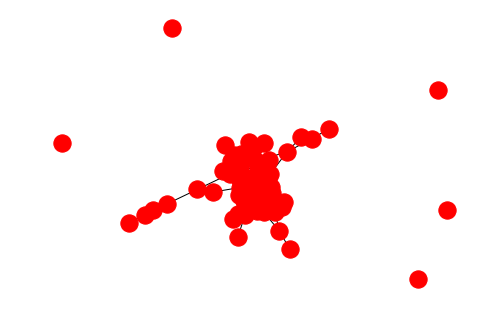

In [75]:
nx.draw(V)
plt.show()

## Algo CLUB

In [69]:
def card_clust(z,n,m,j):
    denom=0
    for i in range(m):
        denom=denom+i^(-z)
    return((n*j^(-z))/denom)

In [70]:
%%capture
for t in range(T):
    print("période t=",t)
    #choisir aléatoirement un user i
    i=int(npr.uniform(0,n_user))
    print("user i=",i)
    list_i.append(i)
    #reçoit contexte C_it généré aléatoirement sur une sphere unitaire
    #C = sphere_unif(D,c)
    #piocher dans un ensemble de profils générés aléatoirement sur t=1...T
    #indique les préférences de user i à période t pour chaque cluster estimé 1...c
    C = list_C[ int( npr.uniform(0,T) ) ]  
    #genère omega
    omega=np.zeros([n_user,D])
    omega[i,:]=np.dot(np.linalg.inv(d_M['M'+str(int(i))]),d_b['b'+str(int(i))])
    #détermine l'indice du cluster de i: j_t(i)
    #calcule M_bar et b_bar et omega aggrégés
    #on récupère tous les indices qui appartiennent au même cluster que celui de i
    M_index = [ n for n in V if nx.has_path(V,n,i)]
    if M_index==[]:   #si le noeud i est tout seul
        M_index=np.array([i])
    M_sum=sum([d_M['M'+str(int(k))] for k in M_index])
    M_bar=np.identity(D)+M_sum-len(M_index)*np.identity(D)
    b_bar=sum([d_b['b'+str(int(k))] for k in M_index])
    #print("M_index",M_index)
    #print("M_bar",M_bar)
    #print("b_bar",b_bar)
    omega_bar=np.dot(np.linalg.inv(M_bar),b_bar)
    #détermine k_t optimal pour cluster j_t(i) --> UCB STRATEGY @cluster level
    vect_k=np.zeros(c)
    for k in range(c):
        CB=alpha*np.sqrt(np.dot(np.dot(C[:,k].T,np.linalg.inv(M_bar)),C[:,k])*np.log(t+1))
        vect_k[k]=CB+np.dot(omega_bar.T,C[:,k])
    k_t=[v for v in range(c) if vect_k[v]==np.max(vect_k)][0]
    #calcule payoffs avec u_j
    a_t=np.dot(U[i,:],C[:,k_t])+npr.uniform(-sigma,sigma,size=1)
    #a_t=(np.dot(U[i],C[:,k_t]))/(np.linalg.norm(U[i])*np.linalg.norm(C[:,k_t]))+npr.uniform(-sigma,sigma,size=1)
    #regret
    other_payoff= list([ np.dot(U[i,:],C[:,n]) for n in range(c) ])
    #other_payoff= list([ np.dot(U[n],C[:,n])/(np.linalg.norm(U[n])*np.linalg.norm(C[:,n])) for n in range(c)] )
    if t>0:
        regret_cum[t]=regret_cum[t-1]+a_t-[np.dot(U[i,:],C[:,n]) for n in range(c) if np.dot(U[i,:],C[:,n])==max(other_payoff)][0]
    else:
        regret_cum[t]=a_t-[np.dot(U[i,:],C[:,n]) for n in range(c) if np.dot(U[i,:],C[:,n])==max(other_payoff)][0]
    list_payoff.append(a_t)
    #update weights
    d_M['M'+str(int(i))]=d_M['M'+str(int(i))]+np.dot(C[:,k_t],C[:,k_t].T)
    d_b['b'+str(int(i))]=d_b['b'+str(int(i))]+a_t*C[:,k_t]
    #update clusters
    T_i=list_i.count(i)-1  #nombre de user i piochés sur les périodes précédentes (exclue période t actuelle)
    #if list_i.count(i)==1: #cas spécifique pour lorsque i est pioché pour la 1ère fois
    #    T_i=1
    CB_tild=np.zeros(n_user) #calcul des bornes de confiance pour tous les user
    CB_tild[i]=alpha2*np.sqrt((1+np.log(1+T_i))/(1+T_i)) #CB pour i, on en a besoin dans la boucle sur les autres users
    nodes_i=[k for k in V[i]]
    print("voisins de i",nodes_i)
    list_CB[t]=CB_tild[i].copy()
    for l in nodes_i: #CB pour les autres users voisins de i
        T_i=list_i.count(l)-1
        if list_i.count(l)==0:
            T_i=0
        CB_tild[l]=alpha2*np.sqrt((1+np.log(1+T_i))/(1+T_i))
        omega[l,:]=np.dot( np.linalg.inv(d_M['M'+str(l)]) , d_b['b'+str(l)] )
        norm_diff_omega=euclidean(omega[l,:],omega[i,:])
        #print( "Confidence bounds: \n" , CB_tild[l] + CB_tild[i] )
        #print("omega norm: \n", norm_diff_omega)
        list_CB[t]=list_CB[t]+CB_tild[l]
        list_omega[t]=list_omega[t]+norm_diff_omega
        if (norm_diff_omega > (CB_tild[l] + CB_tild[i]) ): #si la distance entre users i et l est grande, on brise le lien
            V.remove_edge(i,l)
            """
            V_copy=V.copy()
            V_copy.remove_edge(i,l)
            m_copy=len( list( nx.connected_component_subgraphs(V) ) )
            #list_card=[card_clust(3,n_user,m_copy,j) for j in np.arange(1,m_copy)]
            #list_card_V=[len(c) for c in list(nx.connected_component_subgraphs(V_copy)) ]            
            #if( (nx.has_path(V_copy,i,l)) or (sorted(list_card) == sorted(list_card_V)) ):
            len_clusters=[len(c) for c in list(nx.connected_component_subgraphs(V_copy)) ] 
            if( (nx.has_path(V_copy,i,l)) or ( min(len_clusters)> int(np.sqrt(n_user)/c)) ):
                V.remove_edge(i,l)        
            """    
            print("brise le lien entre users",i,"et",l)
    #update le nombre de sous-graphes i.e. nombre de clusters at la période t
    m=len( list( nx.connected_component_subgraphs(V) ) )
    print("nouveau nombre de clusters:",m)
    list_m.append(m)
    """
    if m > m_prev: # si j'ai créé un nouveau cluster, alors je re-mélange les éléments dans chaque cluster
        #re-melange les noeuds de chaque cluster
        V_new=nx.Graph()
        for clt in list(nx.connected_component_subgraphs(V)):
            n_user_cluster=len(clt)
            print("nouveau nombre de noeuds:",n_user_cluster)
            new_cluster=nx.dense_gnm_random_graph(n_user_cluster,max(1,int(np.log(n_user_cluster)*n_user_cluster)) )
            #un nouveau sous-graphe est généré, on doit maintenant lui donner les bons indices
            index_clt=[i for i in clt]
            label_nodes={}
            for lab in range(len(index_clt)):
                label_nodes[lab]=index_clt[lab]
            new_cluster=nx.relabel_nodes(new_cluster,label_nodes)
            #while (len( list( nx.connected_component_subgraphs(new_cluster) ) ) >1 ): #condition: tous les noeuds doivent être connectés
            #    new_cluster=nx.dense_gnm_random_graph(n_user_cluster,int(np.log(n_user_cluster)*n_user_cluster))
            V_new=nx.compose(V_new,new_cluster)
        V=V_new.copy()
        """
    print("V_new # clusters:",len( list( nx.connected_component_subgraphs(V) ) ))
    #nx.draw_networkx(V)
    #plt.show()

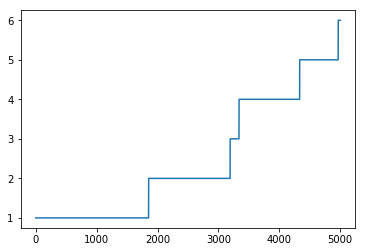

In [71]:
plt.plot(list_m)
plt.show()

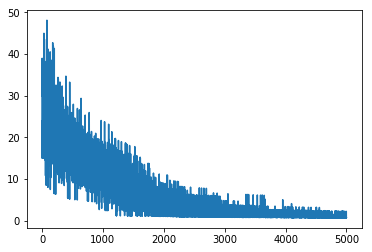

In [30]:
plt.plot(list_CB)
plt.show()

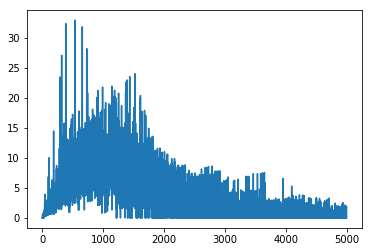

In [31]:
plt.plot(list_omega)
plt.show()

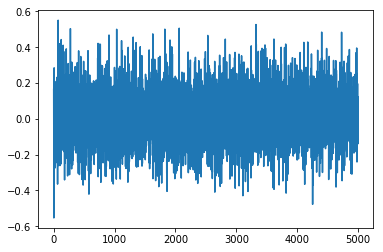

In [76]:
plt.plot(list_payoff)
plt.show()

In [72]:
#mean payoff cumulée
payoff_mean_cum=np.zeros(T)
payoff_vec=np.array(list_payoff)
for i in range(T):
    payoff_mean_cum[i]=np.mean(payoff_vec[:i])

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


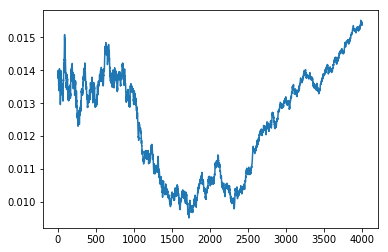

In [73]:
plt.plot(payoff_mean_cum[1000:T])
plt.show()

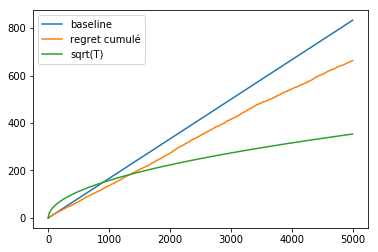

In [74]:
plt.plot(np.arange(T)/6)
plt.plot(-regret_cum)
plt.plot(5*np.sqrt(np.arange(T)))
plt.legend(["baseline","regret cumulé","sqrt(T)"])
plt.show()